# Introduction

In this notebook, we implement [YOLOv4](https://arxiv.org/pdf/2004.10934.pdf) for training on your own dataset in PyTorch.

We also recommend reading our blog post on [Training YOLOv4 on custom data](https://blog.roboflow.ai/training-yolov4-on-a-custom-dataset/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Set up YOLOv4 environment
* Download Custom Dataset via Roboflow
* Train Custom YOLOv4 detector
* Reload Custom YOLOv4 detector weights for inference

When you are done you will have a custom detector that you can use. It will make inference like this:

#### ![Chesse Image](https://i.imgur.com/cGOxffX.png)

### **Reach out for support**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out!](https://roboflow.ai/contact) 


#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Set up YOLOv4 Environment

In [ ]:
#!wget https://app.roboflow.com/ds/7p1fhj4rI1?key=XQu3LdLROj

In [1]:
!git clone https://github.com/roboflow-ai/pytorch-YOLOv4.git

Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 398, done.
remote: Total 398 (delta 0), reused 0 (delta 0), pack-reused 398
Receiving objects: 100% (398/398), 926.53 KiB | 2.85 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [ ]:
%cd /content/pytorch-YOLOv4
!pip install -r requirements.txt

# This restarts the runtime--ignore any error messages
import os
os.kill(os.getpid(), 9)

/content/pytorch-YOLOv4
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 12.6MB 25.6MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 122kB 55.0MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirem

In [1]:
# download yolov4 weights that have already been converted to PyTorch
%cd /content/pytorch-YOLOv4/cfg/
!gdown https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA

/content/pytorch-YOLOv4/cfg
Downloading...
From: https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA
To: /content/pytorch-YOLOv4/cfg/yolov4.conv.137.pth
170MB [00:02, 60.0MB/s]


# Download Custom Dataset

## Export Your Dataset from Roboflow

Roboflow enables you to export your dataset in any format you need - including for this notebook.

Create a [free account](https://app.roboflow.ai). Upload your private dataset. Generate a version (applying any preprocessing and augmentations you desire). Create an export. Select **YOLOv4 PyTorch** as the export format. Click **"Show Download code"**, copy your link, and paste it in the next cell. Magic.

In [2]:
# REPLACE this link with your Roboflow dataset (export as YOLOv4 PyTorch format)
%cd /content/
!curl -L "https://app.roboflow.com/ds/7p1fhj4rI1?key=XQu3LdLROj" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1287      0 --:--:-- --:--:-- --:--:--  1287
100 1085k  100 1085k    0     0  1046k      0  0:00:01  0:00:01 --:--:-- 1046k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.txt   
 extracting: test/_classes.txt       
 extracting: test/image-1048_jpeg.rf.5820ad2013a56132fb4f07000c2a3d50.jpg  
 extracting: test/image-1050_jpeg.rf.85f9b8087a867d190481f265d69d7d78.jpg  
 extracting: test/image-987_jpeg.rf.53e566b25595bb9ca3b935f526613d1b.jpg  
   creating: train/
 extracting: train/0cd05e70f8cab575_jpg.rf.45c48b52ead8073a2451cc8578111d2e.jpg  
 extracting: train/0fa0555fc9a83e1e_jpg.rf.06d7e042377657279e05e4a1d4dd821f.jpg  
 extracting: train/2cdde3ee5a6439f4_jpg.rf.01e607b913b0396c3d50a6141c05217e.jpg  
 extracting: train/3657b32

In [3]:
%cp train/_annotations.txt train/train.txt
%cp train/_annotations.txt train.txt
%mkdir data
%cp valid/_annotations.txt data/val.txt
%cp valid/*.jpg train/

In [4]:
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_classes.txt')

In [5]:
print(num_classes)

1


In [ ]:
!ls -al

In [6]:
cd /content/

/content


In [ ]:
print(num_classes)

# Train Custom Detector

In [7]:
#start training
#-b batch size (you should keep this low (2-4) for training to work properly)
#-s number of subdivisions in the batch, this was more relevant for the darknet framework
#-l learning rate
#-g direct training to the GPU device
#pretrained invoke the pretrained weights that we downloaded above
#classes - number of classes
#dir - where the training data is
#epoch - how long to train for
#!python ./pytorch-YOLOv4/train.py -b 2 -s 1 -l 0.001 -g 0 -pretrained /content/pytorch-YOLOv4/cfg/yolov4.conv.137.pth -classes {num_classes} -dir ./train -epochs 50
!python ./pytorch-YOLOv4/train.py -b 2 -s 1 -l 0.001 -g 0 -pretrained /content/pytorch-YOLOv4/cfg/yolov4.conv.137.pth -classes {num_classes} -dir ./train -epochs 200

log file path:log/log_2021-05-09_11-53-37.txt
2021-05-09 11:53:37,259 train.py[line:435] INFO: Using device cuda
2021-05-09 11:53:40,812 train.py[line:282] INFO: Starting training:
        Epochs:          200
        Batch size:      2
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   23
        Validation size: 6
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 1
        Train label path:train.txt
        Pretrained:
    
Epoch 1/200:   0%|        | 0/23 [00:00<?, ?img/s]/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/200:  96%|▉| 22/23 [00:03<00:00,  8.53img/2021-05-09 11:53:44,866 train.py[line:360] INFO: Created checkpoint directory
2021-05-09 11:53:45,300 train.py[line:364] INFO: Checkpoint 1 sav

# Load Trained Weights for Custom Detection

You can also use this to load previously saved weights!

In [ ]:
#looking at the weights that our model has saved during training
!ls checkpoints

In [8]:
#choose random test image
import os
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

In [9]:
img_path

'test/image-1050_jpeg.rf.85f9b8087a867d190481f265d69d7d78.jpg'

In [11]:
%%time
##change the epoch here to the one you would like to use for inference
!python /content/pytorch-YOLOv4/models.py {num_classes} checkpoints/Yolov4_epoch199.pth {img_path} test/_classes.txt

person: 1.000000
person: 1.000000
person: 1.000000
save plot results to predictions.jpg
CPU times: user 53.3 ms, sys: 8.48 ms, total: 61.7 ms
Wall time: 6.65 s


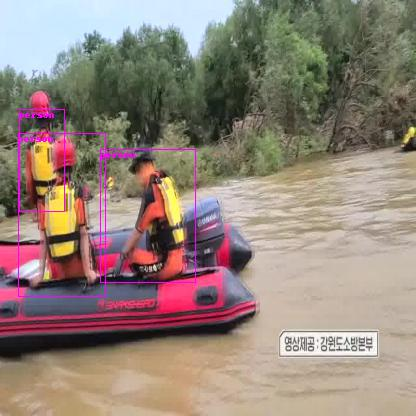

In [12]:
#visualize inference
from IPython.display import Image
Image('predictions.jpg')